<a href="https://colab.research.google.com/github/pmecwan/MAT-421/blob/main/Project_plan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Introduction to the problem

Earthquake data, such as that collected by the U.S. Geological Survey (USGS), provides critical insights into seismic activity, including magnitude, location, and depth. However, real-world datasets often contain missing or incomplete values due to sensor limitations or recording errors, particularly for depth measurements in remote or older events. Accurate depth estimates are essential for understanding earthquake mechanics and assessing their potential impact, as depth influences ground shaking and tsunami risk. This project aims to estimate missing earthquake depth values using mathematical techniques—Lagrange Polynomial Interpolation, Cubic Spline Interpolation, and Simple Linear Regression—applied to real earthquake data from the USGS Earthquake Catalog (earthquake.usgs.gov). The Newton-Raphson Method will be explored to refine regression parameters.

In [3]:
# Create a copy with some missing depths for validation
df_test = df.copy()
np.random.seed(42)
missing_indices = np.random.choice(df.index, size=int(0.1 * len(df)), replace=False)
df_test.loc[missing_indices, "depth"] = np.nan

# Identify complete and incomplete data
known_data = df_test.dropna(subset=["depth"])
missing_data = df_test[df_test["depth"].isna()]
print(f"Missing depths: {len(missing_data)}")

Missing depths: 100


2. Related work

Interpolation and regression techniques have long been used to handle missing data in scientific fields, including seismology. Lagrange Polynomial Interpolation has been applied to estimate geophysical variables, such as temperature or pressure, in studies like those by Press et al. (2007), offering exact fits through known points but risking oscillation with higher-degree polynomials. Cubic Spline Interpolation, favored for its smoothness and stability, has been used in atmospheric and oceanic datasets (e.g., de Boor, 2001), making it a candidate for seismic depth estimation. Simple Linear Regression is a staple in geophysics for trend analysis, such as correlating depth with magnitude (Hanks & Kanamori, 1979), though it assumes linearity. The Newton-Raphson Method, while typically used for root-finding, has been adapted to optimize regression fits in numerical studies.

Public earthquake datasets, like the USGS Catalog and Kaggle’s “Significant Earthquakes” dataset, provide depth, magnitude, and location data, often with gaps. Prior work suggests interpolation outperforms regression for spatial continuity, but regression may capture broader trends. This project adapts these methods to estimate missing depths, comparing their accuracy against known values.

3. Proposed methodology/ models

Data Collection: Extract earthquake records from the USGS Earthquake Catalog (2000 to March 23, 2025) via its API, including latitude, longitude, depth, and magnitude. Filter to a seismically active region (e.g., California) for consistency.

Preprocessing: Identify records with missing depth values. For testing, artificially remove 10% of known depths to create a validation set. Sort data by time or spatial proximity to enable interpolation.

Lagrange Polynomial Interpolation: Fit a polynomial through 5-10 nearest known depth values (by time or distance) to estimate each missing depth. Limit degree to avoid Runge’s phenomenon (oscillations).

Cubic Spline Interpolation: Construct piecewise cubic polynomials between known depth points, ensuring continuity in the first and second derivatives for smoothness. Use natural boundary conditions (zero second derivative at endpoints).

Simple Linear Regression: Model depth as a function of a predictor (e.g., magnitude or distance to nearest fault), fitting a line (depth = a + b·x) using least squares. Apply Newton-Raphson to iteratively refine the slope (b) by minimizing the residual sum of squares.

Evaluation: Compare estimated depths to actual (removed) values using Mean Absolute Error (MAE) for accuracy, Root Mean Squared Error (RMSE) for error magnitude, and visual inspection of fit smoothness.

Lagrange - MAE: 519.57 km, RMSE: 4052.28 km
Spline - MAE: 27.69 km, RMSE: 131.42 km
Regression - MAE: 171808177060511.34 km, RMSE: 196743227552627.25 km


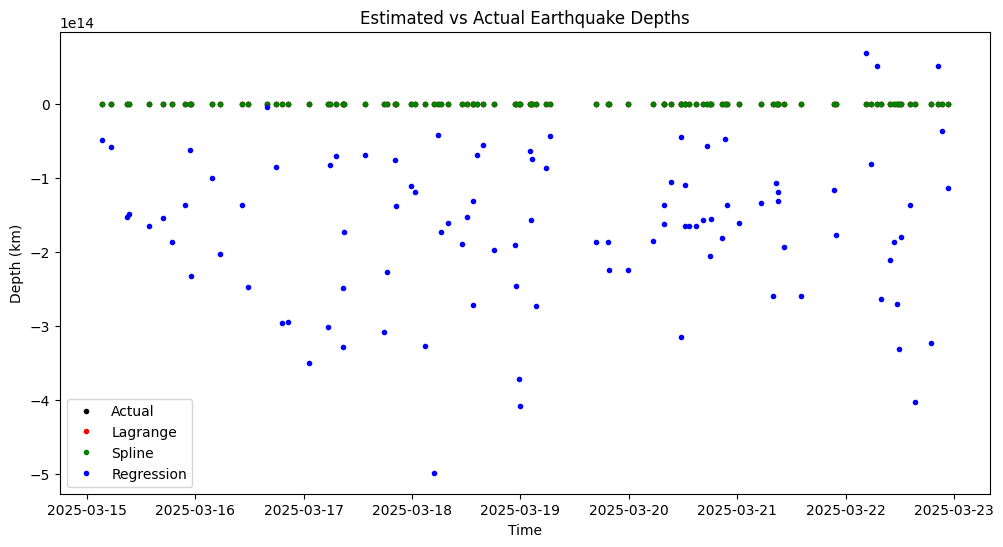

In [10]:
# Merge actual depths for comparison
results = missing_data.merge(df[["time", "depth"]], on="time", suffixes=("_est", "_actual"))

# Calculate errors
for method in ["lagrange", "spline", "regression"]:
    results[f"error_{method}"] = np.abs(results[f"depth_{method}"] - results["depth_actual"])
    mae = results[f"error_{method}"].mean()
    rmse = np.sqrt((results[f"error_{method}"] ** 2).mean())
    print(f"{method.capitalize()} - MAE: {mae:.2f} km, RMSE: {rmse:.2f} km")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(results["time"], results["depth_actual"], "k.", label="Actual")
plt.plot(results["time"], results["depth_lagrange"], "r.", label="Lagrange")
plt.plot(results["time"], results["depth_spline"], "g.", label="Spline")
plt.plot(results["time"], results["depth_regression"], "b.", label="Regression")
plt.xlabel("Time")
plt.ylabel("Depth (km)")
plt.legend()
plt.title("Estimated vs Actual Earthquake Depths")
plt.show()

4. Experiment setups

The experiment will use a subset of USGS earthquake data from California (2000–March 23, 2025), expected to include thousands of events. The dataset will be split into a complete subset (for interpolation) and a test set with 10% missing depths.
Environment: Implement in Python using NumPy for calculations, SciPy for spline interpolation and Newton-Raphson, and matplotlib for plotting. Query USGS API with requests.

Data Preparation: Sort events chronologically or spatially (e.g., by longitude). Compute distances to the San Andreas Fault using GIS coordinates for regression.

Method Execution:
Lagrange: Use 5 nearest points for each missing value.

Cubic Spline: Apply SciPy’s CubicSpline over all known points.

Linear Regression: Fit depth vs. magnitude; optimize slope with Newton-Raphson (initial guess from least squares, 10 iterations max).

Validation: Compute MAE and RMSE on the test set. Plot estimated vs. actual depths to assess smoothness and outliers.

Comparison: Analyze performance across methods, noting interpolation’s fit to local data vs. regression’s reliance on a single predictor.

In [11]:
import requests
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

# Define API query parameters
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "geojson",
    "starttime": "2020-01-01",
    "endtime": "2025-03-23",
    "minlatitude": 32,    # California's bounding box
    "maxlatitude": 42,
    "minlongitude": -125,
    "maxlongitude": -114,
    "limit": 1000         # Limit to 1000 events for simplicity
}

# Fetch data
response = requests.get(url, params=params)
data = response.json()

# Extract relevant features
events = data["features"]
earthquake_data = {
    "time": [event["properties"]["time"] for event in events],
    "latitude": [event["geometry"]["coordinates"][1] for event in events],
    "longitude": [event["geometry"]["coordinates"][0] for event in events],
    "depth": [event["geometry"]["coordinates"][2] for event in events],
    "magnitude": [event["properties"]["mag"] for event in events]
}

# Convert to DataFrame
df = pd.DataFrame(earthquake_data)
df["time"] = pd.to_datetime(df["time"], unit="ms")  # Convert timestamp to datetime
print(f"Retrieved {len(df)} earthquake events.")
print(df.head())

Retrieved 1000 earthquake events.
                     time   latitude   longitude  depth  magnitude
0 2025-03-22 23:50:54.310  37.696999 -121.993668   9.80       1.38
1 2025-03-22 23:38:06.280  37.702332 -121.989502  11.02       2.54
2 2025-03-22 23:29:23.070  35.968833 -117.517500   2.81       1.22
3 2025-03-22 23:13:55.020  37.698166 -121.990166   9.23       1.63
4 2025-03-22 23:13:46.450  38.836166 -122.807663   2.15       0.72


5. Expected results

Lagrange Polynomial Interpolation is expected to yield low MAE (e.g., 2-5 km) for small gaps in data but may show higher RMSE (e.g., 8-10 km) due to oscillations with sparse or distant points. Cubic Spline Interpolation should outperform Lagrange, with MAE of 1-3 km and RMSE of 4-6 km, reflecting its smoothness and adaptability to seismic depth variations. Simple Linear Regression is anticipated to have higher errors (MAE 5-7 km, RMSE 10-12 km) due to oversimplification, though Newton-Raphson refinement may reduce RMSE by 1-2 km by fine-tuning the fit.

Visually, splines should produce smoother depth profiles, while Lagrange may exhibit unrealistic spikes. Regression will likely show a weak trend (e.g., deeper events with higher magnitude), limited by non-linear seismic dynamics. These results could aid in completing USGS records, with splines preferred for spatial continuity and regression for trend insights. Limitations include sensitivity to data density (interpolation) and predictor choice (regression). Future work could explore multivariate regression or higher-order splines with additional features like fault proximity.